In [92]:
import random
import torch
from d2l import torch as d2l

### 生成数据集

In [93]:
# synthetic ==> 人造的、合成的
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [94]:
true_w = torch.tensor([2, -3.4]) # 权重向量
true_b = 4.2 # 偏置量
# 给出一个线性的真实权重（x 的系数）以及 真实的偏置量
# 最后是希望生成的数据的个数，由 w 可以知道特征的维度
features, labels = synthetic_data(true_w, true_b, 1000)

In [95]:
# 观察到 特征是二维的
print('features:', features[0])
print('label:', labels[0])

features: tensor([-1.1366, -0.9857])
label: tensor([5.2760])


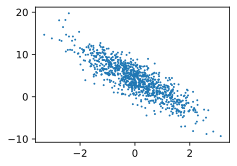

In [96]:
# 绘图 ==> 说明数据是线性关系
d2l.set_figsize()
# 表明只要第 1 号维度的特征并转化成 numpy 的 array，以及 labels==>y
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据

In [97]:
# 生成大小为 batch_size 的数据 ==> 从 features 和 labels 的数据进行打乱
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [98]:
# 读取小批量数据并打印
batch_size = 100

for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[ 2.7625e+00, -1.9946e-01],
        [-1.0902e+00,  4.6603e-01],
        [-2.9016e+00, -7.7048e-01],
        [-1.8072e-01, -1.3462e+00],
        [-1.5729e-01, -1.3519e+00],
        [ 3.2435e-01,  1.8749e+00],
        [-4.5674e-01, -2.0598e+00],
        [ 2.1294e-01, -2.7541e-01],
        [ 4.6636e-01,  6.8001e-01],
        [ 1.4462e+00, -1.4226e-01],
        [ 1.2283e+00, -3.4338e-01],
        [ 2.3355e+00, -3.0516e-01],
        [-2.1450e-01,  1.2922e-01],
        [ 2.0104e+00,  8.6215e-01],
        [ 2.3621e-01,  9.4467e-02],
        [-2.7842e-01, -1.8389e-01],
        [ 8.6401e-01, -4.3901e-01],
        [ 5.8824e-01, -1.2803e+00],
        [-8.6254e-01,  3.1606e-01],
        [ 9.5231e-01, -2.1778e+00],
        [ 4.8621e-01, -1.5973e-01],
        [ 5.0244e-01, -3.5937e-02],
        [ 2.0856e+00,  1.2793e+00],
        [ 8.3165e-02,  1.0426e+00],
        [-6.8576e-01, -1.1065e+00],
        [-1.2608e+00,  1.7617e-01],
        [ 7.8802e-01, -1.3537e+00],
        [ 4.6939e-01, -5.332

### 随机初始化线性模型的参数

In [99]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[ 0.0064],
         [-0.0019]], requires_grad=True),
 tensor([0.], requires_grad=True))

### 定义模型

In [100]:
# 广播机制
# 当使用一个向量 加上 一个标量的时候
# 标量 b 会依次加到向量的每个分量上去
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [101]:
# 这个损失函数没有求和
# 得到的损失值是对多个样本的损失值的一个向量
# 这个向量中的每个元素记录的是对某一个样本的损失值
# 调用 squared_loss 函数后 ==> 对这个向量求和 ==> 聚合运算就可以了
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义 SGD 优化函数

In [102]:
# 加上 torch.no_grad() 后
# ==> 所执行的计算不会被记录在反向传播中
# 就是暂时性地忽略 requires_grad 属性为 True 的事实
# 这里的 SGD 只是用来更新权重的
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        # 更新 w 的过程不应该被记录和追踪
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [103]:
lr = 0.03 # 学习率
num_epochs = 100 # 训练次数
net = linreg # 训练的网络的名称
loss = squared_loss # 损失函数

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # net(X, w, b) ==> 这其实就是正向传播的过程
        # net(X, w, b) 等价于 y_hat
        # 再计算 y 和 y_hat 之间的损失即可
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # 通过这里计算出梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
        
    # 每完成一轮数据集的训练之后
    # 就输出一些信息，来查看当前的损失状态
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 9.018119
epoch 2, loss 4.880241
epoch 3, loss 2.646266
epoch 4, loss 1.437895
epoch 5, loss 0.782632
epoch 6, loss 0.426733
epoch 7, loss 0.233071
epoch 8, loss 0.127489
epoch 9, loss 0.069837
epoch 10, loss 0.038323
epoch 11, loss 0.021068
epoch 12, loss 0.011604
epoch 13, loss 0.006407
epoch 14, loss 0.003552
epoch 15, loss 0.001981
epoch 16, loss 0.001114
epoch 17, loss 0.000638
epoch 18, loss 0.000375
epoch 19, loss 0.000229
epoch 20, loss 0.000149
epoch 21, loss 0.000105
epoch 22, loss 0.000080
epoch 23, loss 0.000067
epoch 24, loss 0.000059
epoch 25, loss 0.000055
epoch 26, loss 0.000053
epoch 27, loss 0.000051
epoch 28, loss 0.000051
epoch 29, loss 0.000050
epoch 30, loss 0.000050
epoch 31, loss 0.000050
epoch 32, loss 0.000050
epoch 33, loss 0.000050
epoch 34, loss 0.000050
epoch 35, loss 0.000050
epoch 36, loss 0.000050
epoch 37, loss 0.000050
epoch 38, loss 0.000050
epoch 39, loss 0.000050
epoch 40, loss 0.000050
epoch 41, loss 0.000050
epoch 42, loss 0.000050
e

In [104]:
# 因为这是自己合成的数据集
# 所以可以计算下，训练出来的 w 的值和 true_w 之间的差距
# 以及 true_b 和 b 的差距
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003, -0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)


### 我的小结

在之前的时候，我一直很困惑的是，当在线性回归的输入中一次性输入多个样本的时候，在最终的损失函数那里应该怎么处理？因为当输入多个样本的时候，转化成向量计算，可以计算出一个损失向量，这个损失向量包含了这一次输入的样本的个数那么多的损失值。想要表量化这个损失向量，非常简单，只需要使用 sum() 来聚合一下损失值，就可以把多个样本的损失值变成一个标量来看待了。

调用 backward 计算梯度，然后再使用 SGD 函数更新参数的值，在更新参数的值时，因为参数参与了运算，但是这个并不是正向传播的过程，不应该被记录下来

那么，在更新权重的值的时候，需要使用到样本数据吗？

不需要！因为在更新权重的时候，只需要使用 w <- w + (-lr*w.grad) 即可；这表明实在以 w 现在的位置为基础，然后移动一段距离，得到一个新的 w 然后赋值回去

w <- w + (-lr*w.grad) ==> w -= lr\*w.grad